In [1]:
import sys
import argparse
import os
import numpy as np
from scipy.signal import get_window
from skimage.util import view_as_windows,view_as_blocks
from utilities.config_handler import get_config
from utilities.visualization import plot_spectogram
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate , get_blocks_by_time,trim_by_slice_length,compute_fft_train_data , load_raw_data , compute_fft_train_data \
, compute_fft_test_data,trim_iq_basic_block, complex2power
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from scipy.stats import entropy
from scipy.signal import welch,detrend
from scipy.fftpack import fft,rfft,fftshift,fft2
%matplotlib inline

Using TensorFlow backend.


In [2]:
normal_records = ['CELL_NORM_2', 'CELL_NORM_3', 'CELL_NORM_4']
anomal_records = ['CELL_SWP_18MHz_50us_0dB', \
          'CELL_SWP_18MHz_50us_10dB', 'CELL_SWP_18MHz_100us_0dB', 'CELL_SWP_18MHz_100us_10dB',
                 'CELL_SWP_45MHz_20us_0dB','CELL_SWP_45MHz_20us_10dB']

normal_path='iq_data/CELL/normal'
anomal_path='iq_data/CELL/anomal'

In [3]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory',nargs='?')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


# sys.argv = "-m test -d -w model/baseline_cepstrum".split()
# sys.argv = "-m test -d iq_data/CELL/anomal/CELL_SWP_18MHz_50us_10dB -w model/baseline_cepstrum".split()
sys.argv = "-m train -d iq_data/CELL/normal/CELL_NORM_0 -w model/baseline_cepstrum".split()

namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

# if not namespace.data_dir and namespace.mode == 'test':
#     parser.error('the -d arg must be present when mode is test')

if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')
    
train = namespace.mode == 'train'

In [4]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
fft_window_name = conf['preprocessing']['ae']['window']
basic_block_interval = conf['preprocessing']['basic_time']


median_kernel_size = 11
cepstrum_window_size = 512
cv_types = ['diag']

In [5]:
def compute_frequency_spectrum(freq):
    num_samples = len(freq)
    freq = freq - np.mean(freq)
    window = get_window(fft_window_name, num_samples)
    fft_data = ((rfft(window*freq)))
    return fft_data

In [6]:
def compute_welch_spectrum(freq):
    freq = freq - np.mean(freq)
    return welch(freq, nperseg=cepstrum_window_size , \
      noverlap=3*cepstrum_window_size//4 , scaling = 'spectrum',window='hann')[1]

In [7]:
def train_cepstrum2d(data_dir,rbw):
    dataset_name = str.split(data_dir, '/')[1]
    recording_name = str.split(data_dir,'/')[-1]
    sample_rate = get_xhdr_sample_rate(data_dir)
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)

    iq_data = load_raw_data(normal_data_dir)
    iq_data_blocks = get_blocks_by_time(iq_data,sample_rate)
    
    block_spectograms = [compute_fft_train_data(iq_block,sample_rate,rbw,weights_path)[2]\
                         for iq_block in iq_data_blocks]
    
    #Compute the per-frequency train mean and std, assuming it's the same for all time blocks
    _ , train_freq_means = np.broadcast_arrays(block_spectograms[0] , np.mean(block_spectograms[0],axis=0))
    _ , train_freq_stds = np.broadcast_arrays(block_spectograms[0] , np.std(block_spectograms[0],axis=0))
    
    #Z-score per-frequency for each spectogram
    block_spectograms = [normalize_frequency(spectogram) for spectogram in block_spectograms]
    
    #Split each spectogram to overlapping windows, remove it's DC and compute 2D fft for each window
    fft2d_blocks_list = [computefft2d_blocks(spectogram) for spectogram in block_spectograms]
    max_train_blocks = compute_max_windows(fft2d_blocks_list)
    
    persist_object(train_freq_means , os.path.join(weights_path,'train_freq_means.pkl'))
    persist_object(train_freq_stds , os.path.join(weights_path,'train_freq_stds.pkl'))
    persist_object(max_train_blocks , os.path.join(weights_path,'max_train_blocks.pkl'))

In [8]:
def test_cepstrum2d(data_dir,rbw):
    sample_rate = get_xhdr_sample_rate(data_dir)
    dataset_name = str.split(data_dir, '/')[1]
    recording_name = str.split(data_dir,'/')[-1]
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)
    
    iq_data = load_raw_data(anomaly_data_dir)
    iq_data = trim_iq_basic_block(iq_data , sample_rate)
    _, _, fft_test = compute_fft_test_data(iq_data,sample_rate,rbw,weights_path)
    
    train_freq_means = load_object(os.path.join(weights_path,'train_freq_means.pkl'))
    train_freq_stds = load_object(os.path.join(weights_path,'train_freq_stds.pkl'))
    fft_test = (fft_test - train_freq_means) / train_freq_stds

In [ ]:
if train:
    data_dir = namespace.data_dir
    for rbw in rbw_set:
        train_cepstrum(data_dir,rbw)
else:
    #Case we evaluate on set of fixed test sets
    if not namespace.data_dir:
        for r in normal_records:
            data_dir = os.path.join(normal_path, r)
            for rbw in rbw_set:
                test_cepstrum(data_dir,rbw)
                
        for r in anomal_records:
            data_dir = os.path.join(anomal_path,r)
            f_s = get_xhdr_sample_rate(data_dir)
            for rbw in rbw_set:
                test_cepstrum(data_dir,rbw)
    else:
        data_dir = namespace.data_dir
        assert len(data_dir) != 0
        for rbw in rbw_set:
            test_cepstrum(data_dir,rbw)

# Expriement

In [9]:
def compute_welch_spectrum(freq):
    freq = freq - np.mean(freq)
    return welch(freq, nperseg=512 , \
      noverlap = 3*512//4, scaling = 'spectrum',window='hann')[1]

# sweep_freq = fft_train[:,250]
# fig , (ax1 , ax2) = plt.subplots(2,1,figsize=(10,10))
# cepstrum_sample_plot_path = os.path.join(data_dir,"cepstrum_sample.png")
# ax1.plot(sweep_freq)
# ax1.set_title('Sweep frequency plot')
# ax2.plot(np.abs(compute_welch_spectrum(sweep_freq)))
# ax2.set_title('fft of frequency')
# plt.show()

In [7]:
def normalize_frequency(fft):
    freqs_mean = np.mean(fft , axis=0)
    freqs_std = np.std(fft , axis=0)

    fft , freqs_mean = np.broadcast_arrays(fft , freqs_mean)
    fft , freqs_std = np.broadcast_arrays(fft , freqs_std)

    fft_block = (fft - freqs_mean) / freqs_std
    return fft_block

In [8]:
def compute_fft2(data):
    return np.abs(fftshift(fft2(data),axes=(-2,-1)))

In [9]:
def computefft2d_blocks(spectogram):
    window_shape = spectogram.shape[0] , spectogram.shape[1] // 4
    overlap = (window_shape[0] , window_shape[1]//2)
    #Split spectogram to overlapping windows
    fft2d_blocks = view_as_windows(spectogram,window_shape,overlap)
    fft2d_blocks = fft2d_blocks.reshape((-1,fft2d_blocks.shape[2],fft2d_blocks.shape[3]))
    #Remove DC
    fft2d_blocks = np.apply_along_axis(lambda x: x-np.mean(x),0,fft2d_blocks)
    #Computes for each window it's 2d fft (with 50% overlap) and takes abs
    fft2d_blocks = compute_fft2(fft2d_blocks)
    return fft2d_blocks

In [10]:
def compute_max_windows(fft2d_blocks_list):
    max_train_blocks = np.zeros(fft2d_blocks_list[0].shape)
    for i in range(fft2d_blocks_list[0].shape[0]):
        max_block_i = np.zeros(fft2d_blocks_list[0].shape[1:3]) #init max
        for ff2d_block in fft2d_blocks_list:
            max_block_i = np.maximum(ff2d_block[i,:,:],max_block_i)
        max_train_blocks[i,:,:] = max_block_i
    return max_train_blocks

In [11]:
normal_data_dir = 'iq_data/CELL/normal/CELL_NORM_0'
rbw=125e3
dataset_name = str.split(normal_data_dir, '/')[1]
recording_name = str.split(normal_data_dir,'/')[-1]
sample_rate = get_xhdr_sample_rate(normal_data_dir)
weights_dir = "_".join((dataset_name, str(rbw)))
weights_path = os.path.join(namespace.weights_path, weights_dir)

iq_data = load_raw_data(normal_data_dir)
iq_data_blocks = get_blocks_by_time(iq_data,sample_rate,delta_t = 0.001)

In [12]:
block_spectograms = [compute_fft_train_data(iq_block,sample_rate,rbw,weights_path)[2] for iq_block in iq_data_blocks][:20]

In [13]:
#Compute the per-frequency train mean and std, assuming it's the same for all time blocks
_ , train_mean = np.broadcast_arrays(block_spectograms[0] , np.mean(block_spectograms[0],axis=0))
_ , train_std = np.broadcast_arrays(block_spectograms[0] , np.std(block_spectograms[0],axis=0))

In [14]:
#Z-score per-frequency for each spectogram
block_spectograms = [normalize_frequency(spectogram) for spectogram in block_spectograms]

In [15]:
#Split each spectogram to overlapping windows, remove it's DC and compute 2D fft for each window
fft2d_blocks_list = [computefft2d_blocks(spectogram) for spectogram in block_spectograms]

In [16]:
max_train_blocks = compute_max_windows(fft2d_blocks_list)

In [17]:
anomaly_data_dir = 'iq_data/CELL/normal/CELL_NORM_4'
rbw=125e3
dataset_name = str.split(anomaly_data_dir, '/')[1]
recording_name = str.split(anomaly_data_dir,'/')[-1]
sample_rate = get_xhdr_sample_rate(anomaly_data_dir)
weights_dir = "_".join((dataset_name, str(rbw)))
weights_path = os.path.join(namespace.weights_path, weights_dir)

iq_data = load_raw_data(anomaly_data_dir)
iq_data = trim_iq_basic_block(iq_data , sample_rate)
_, _, fft_test = compute_fft_test_data(iq_data,sample_rate,rbw,weights_path)

In [18]:
def max_argmax(matrix,orig_shape):
    argmax=np.argmax(matrix)
    max_val=matrix[argmax]
    return max_val, (*np.unravel_index(argmax , orig_shape))

In [19]:
def zero_window_row(fft2d_windows):
    for i in range(len(fft2d_windows)):
        height = fft2d_windows.shape[1]
        fft2d_windows[i,height // 2 - 2 : height // 2 +2 , :] = 0
    return fft2d_windows

In [21]:
fft_test = (fft_test - train_mean) / train_std

In [27]:
fft2d_test_windows = computefft2d_blocks(fft_test)

NameError: name 'computefft2d_blocks' is not defined

In [23]:
#Zero out the origin row
fft2d_test_windows = zero_window_row(fft2d_test_windows)

In [24]:
fft2d_windows_flatten = fft2d_test_windows.reshape((fft2d_test_windows.shape[0],-1))

In [25]:
max_test_argmax = np.apply_along_axis(lambda x:max_argmax(x,fft2d_test_windows.shape[1:3]),1,\
                                       fft2d_windows_flatten)

In [28]:
win_ind = 0
for (max_test , i , j) in max_test_argmax:
    print(max_test - max_train_blocks[win_ind,int(i),int(j)])
    win_ind = win_ind + 1

1356.890625
1314.66650390625
343.4410400390625
-1018.0234375
476.9322509765625
494.609375
1482.602294921875


# Plotting

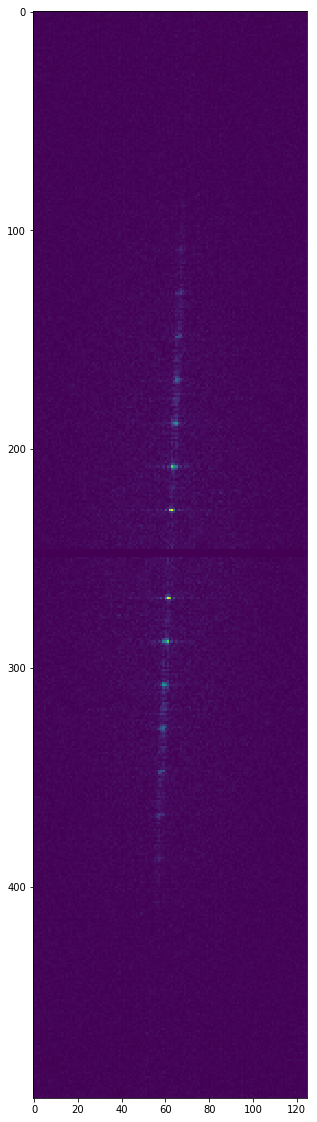

In [72]:
f=plt.figure(figsize=(20,20))
plt.imshow(fft2d_test_windows[2,:,:])

In [ ]:
f = plt.figure(figsize=(20,20))
plt.imshow(fft_train_2d)

In [ ]:
X, Y = np.meshgrid(range(fft_train_2d.shape[1]),range(fft_train_2d.shape[0]))

In [ ]:
np.max(fft_train_2d)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,fft_train_2d)

In [31]:
n=18

In [33]:
n >> 1

9